### BA 713 - Machine Learning and AI
#### Assignment 2
#### Rakeen Ahmed - 301307050

##### 1) Import all the necessary libraries, read the dataset using pandas and analyze the data. For data preparation phase, save the “benign” and “attack” dataframe separately. Drop the “Label” column from the dataset and convert benign and attack dataframes to numpy arrays. Now, split the data into test and train (use 75% observations for train set and the remaining 25% for test set). Then, scale the train and test data using MinMax Scaler. [10% marks].

In [6]:
#import neccesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Lambda
from keras import Model
from keras import metrics, optimizers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

In [3]:
df = pd.read_csv('network_attack_data.csv')

In [4]:
df.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,Label
0,109998919,4,3,525,0.0,520,0,131.25,259.177385,0,...,32,5735.0,0.0,5735.0,5735.0,110000000.0,0.0,110000000.0,110000000.0,1
1,109993343,4,3,531,0.0,520,0,132.75,258.218738,0,...,32,5437.0,0.0,5437.0,5437.0,110000000.0,0.0,110000000.0,110000000.0,1
2,109988359,4,3,535,0.0,520,0,133.75,257.597069,0,...,32,5505.0,0.0,5505.0,5505.0,110000000.0,0.0,110000000.0,110000000.0,1
3,109982960,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5303.0,0.0,5303.0,5303.0,110000000.0,0.0,110000000.0,110000000.0,1
4,109977744,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5356.0,0.0,5356.0,5356.0,110000000.0,0.0,110000000.0,110000000.0,1


In [13]:
#check data shape
df.shape

(28485, 77)

In [12]:
#check number of attack and benign labels
df.Label.value_counts()

0    22987
1     5498
Name: Label, dtype: int64

In [17]:
#assign attack and benign instances to separate dataframes
attack = df.Label == 1
benign = df.Label == 0

df_attack = df[attack]
df_benign = df[benign]

print(f'Attack Data: {len(df_attack)}')
print(f'Benign Data: {len(df_benign)}')

Attack Data: 5498
Benign Data: 22987


In [20]:
#drop label column from dataframes and convert to numpy arrays 
x_attack = df_attack.drop(columns='Label',axis=1).values
y_attack = df_attack['Label'].values

x_benign = df_benign.drop('Label',axis=1).values
y_benign = df_benign['Label'].values

print(f'x_attack shape:{len(x_attack)}')
print(f'x_benign shape:{len(x_benign)}')
print(f'y_attack shape:{len(y_attack)}')
print(f'y_benign shape:{len(y_benign)}')

x_attack shape:5498
x_benign shape:22987
y_attack shape:5498
y_benign shape:22987


In [23]:
#split arrays using train_test_split
x_benign_train, x_benign_test, y_benign_train, y_benign_test = train_test_split(x_benign, y_benign, test_size=0.25, random_state=10)

In [27]:
print(f'x_benign_train shape: {x_benign_train.shape}')
print(f'x_benign_test shape: {x_benign_test.shape}')

x_benign_train shape: (17240, 76)
x_benign_test shape: (5747, 76)


In [28]:
#scale the data using MinMaxScaler
scaler = MinMaxScaler()
x_benign_train_scaled = scaler.fit_transform(x_benign_train)
x_benign_test_scaled = scaler.transform(x_benign_test)
x_attack_scaled = scaler.transform(x_attack)

##### Set the following hyperparameter values: [5% marks]. • batch_size = 64 • num_features= 76 • latent_dim = 5 • number of neurons in the hidden layers= 100 • epochs = 50

In [29]:
# data features
num_features = 76

# Training parameters.
batch_size = 64
epochs = 50

# Neural Network Parameters
hidden_1 = 100 # 1st layer number of neurons
hidden_2 = 100 # 2nd layer number of neurons
latent_dim = 5 

##### 3. Using Keras Functional API, define the encoder, sampling layer, the decoder and instantiate the VAE model. Note both the
encoder and decoder have two hidden layers each. [25% marks]

In [30]:
#define the sampling layer
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [31]:
#define encoder
inputs = Input(shape=(num_features, ), name='input') #num_features = 76 # number of input features
x1 = Dense(hidden_1, activation='relu')(inputs) ## First hidden layer 
x2 = Dense(hidden_2, activation='relu')(x1) ##Second hidden layer
z_mean = Dense(latent_dim, name='z_mean')(x2) ### Latent layer = 5
z_log_var = Dense(latent_dim, name='z_log_var')(x2) #latent_dim = 5

In [32]:
#define sampling/latent layer
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 76)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          7700        ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 100)          10100       ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 5)            505         ['dense_1[0][0]']                
                                                                                            

In [33]:
#define decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x1 = Dense(hidden_2, activation='relu')(latent_inputs) ## First hidden layer 
x2 = Dense(hidden_1, activation='relu')(x1) ## Second hidden layer 
outputs = Dense(num_features, activation='sigmoid')(x2) #num_features = 29 # number of input features

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 5)]               0         
                                                                 
 dense_2 (Dense)             (None, 100)               600       
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 76)                7676      
                                                                 
Total params: 18,376
Trainable params: 18,376
Non-trainable params: 0
_________________________________________________________________


In [34]:
#instantiate VAE model
outputs = decoder(encoder(inputs)[2])  # Select the z value from outputs of the encoder
vae = Model(inputs, outputs, name='vae')

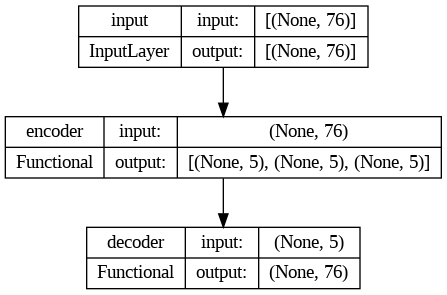

In [35]:
#VAE model structure
keras.utils.plot_model(vae, "VAE_MODEL.png", show_shapes=True)

##### 4) Define the VAE loss function and compile the model using this loss metric and optimizer to be used is Adam. The learning rate value must be 0.001. [10% marks].

In [36]:
# VAE Loss
# Reconstruction loss
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
adam = optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=adam) ##compile the model
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 76)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 5),          18810       ['input[0][0]']                  
                                 (None, 5),                                                       
                                 (None, 5)]                                                       
                                                                                                  
 decoder (Functional)           (None, 76)           18376       ['encoder[0][2]']                
                                                                                                

##### 5) Train the model with batch_size and epochs set above. Display the loss curve during training. Then save the encoder, decoder and vae models (in .h5 format) using model.save. [15% marks].

In [39]:
# Fit Model

history = vae.fit(x_benign_train_scaled, x_benign_train_scaled, verbose = 1, batch_size=batch_size, epochs=epochs,shuffle=True,validation_split=0.2)

Epoch 1/50
216/216 [==============================] - 5s 6ms/step - loss: 3.0729 - val_loss: 1.4677
Epoch 2/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4771 - val_loss: 1.4503
Epoch 3/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4744 - val_loss: 1.4495
Epoch 4/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4642 - val_loss: 1.4415
Epoch 5/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4607 - val_loss: 1.4379
Epoch 6/50
216/216 [==============================] - 1s 6ms/step - loss: 1.4560 - val_loss: 1.4325
Epoch 7/50
216/216 [==============================] - 1s 6ms/step - loss: 1.4538 - val_loss: 1.4257
Epoch 8/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4532 - val_loss: 1.4294
Epoch 9/50
216/216 [==============================] - 1s 5ms/step - loss: 1.4513 - val_loss: 1.4195
Epoch 10/50
216/216 [==============================] - 1s 4ms/step - loss: 1.4470 - val_loss: 1.4232

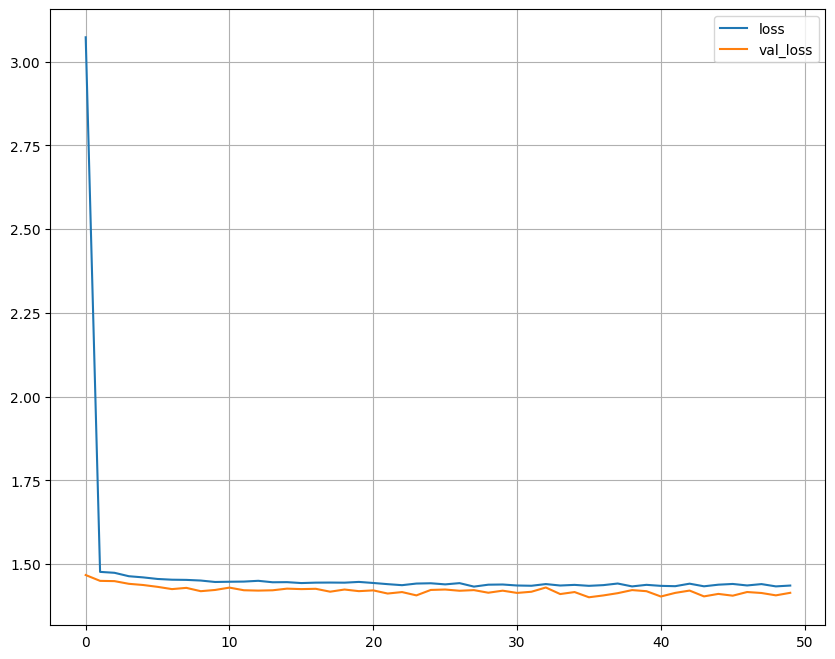

In [45]:
#loss plot of training and validation data

pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.grid(True)
plt.show()

In [46]:
#save model
vae.save("vae_50.h5") 

##### 6) Make predictions on test data using .predict() and visualize your plot comparing benign observations with attack observations. Select the most appropriate threshold value by observing the graph and using trial and error approach. [20% marks].

In [52]:
#predictions on test data

#combine test and attack data
test_obs = x_benign_test_scaled.copy()
test_obs = np.append(test_obs, x_attack_scaled, axis=0)
y_obs = y_benign_test
y_obs = np.append(y_obs, y_attack, axis=0)


#predict on test and attack data
test_preds=vae.predict(test_obs)
mse_test = np.mean(np.power(test_obs - test_preds, 2), axis=1)   
print(mse_test.shape, y_obs.shape)

tst_error_data = pd.DataFrame({'recon_error': mse_test,'Class': y_obs})

352/352 [==============================] - 1s 3ms/step
(11245,) (11245,)


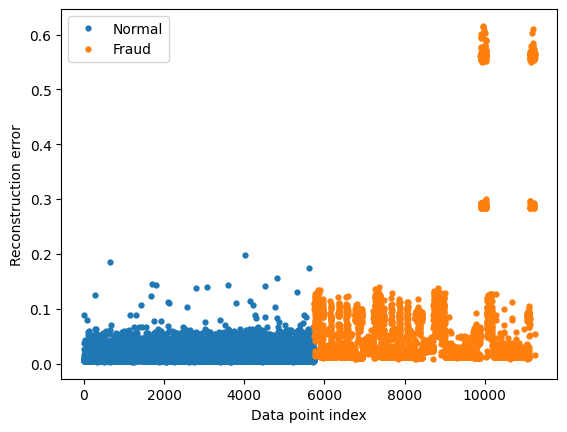

In [53]:
#plotting the data classes

group1 = tst_error_data.groupby('Class')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "Fraud" if name == 1 else "Normal")
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

7) Perform the metric analysis to evaluate the performance of your classifier at your selected threshold. Display the results in terms of TPR, FPR, TNR, FNR, Precision, F1_score and ROC-AUC graph. [15% marks].

In [54]:
# TPR, FPR, TNR, FNR, Precision, F1 Score

threshold=0.05 ##selected using trial and error based on improving the TPR and TNR values

y_pred = [1 if e > threshold else 0 for e in tst_error_data.recon_error.values]

cm= confusion_matrix(tst_error_data.Class, y_pred)
print("Confusion matrix:")
print(cm)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

acc=float(tp+tn)/(tp+tn+fp+fn)

print('\nClassifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)

print('True Positive Rate (TPR/Recall/Sensitivity): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)

print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100)) 

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR): %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("False Negative Rate (FNR): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Precision/Positive Predictive value:%.2f%%" %(precision*100))

fscore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fscore*100))

Confusion matrix:
[[5510  237]
 [3860 1638]]

Total number of true positives 1638
Total number of false negatives 3860
Total number of false positives 237
Total number of true negatives 5510

Classifier Accuracy: 63.57%
True Positive Rate (TPR/Recall/Sensitivity): 29.79%
True Negative Rate (TNR/Specificity/selectivity):95.88%
False Positive Rate (FPR): 4.12%
False Negative Rate (FNR): 70.21%
Precision/Positive Predictive value:87.36%
F1-Score: 44.43%


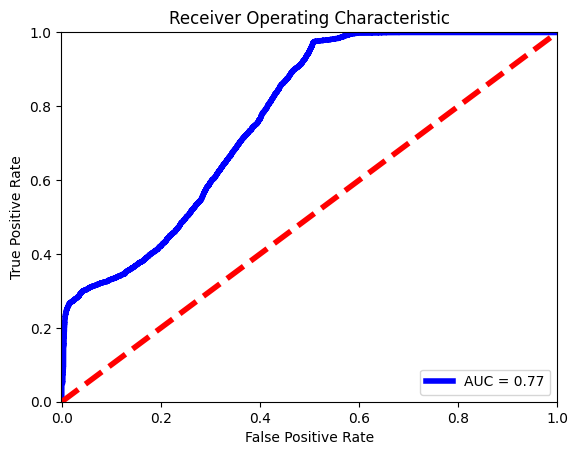

In [59]:
# ROC-AUC Curve

fpr, tpr, thresholds = roc_curve(tst_error_data.Class,tst_error_data.recon_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 4, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()